In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split 

In [9]:
# Bibliotecas necessárias
# Manipulação de dados
import pandas as pd
# Redes Neurais
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
# Plot
import matplotlib.pyplot as plt
%matplotlib inline
# Avaliação
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np
import time
import os

## Prepare Data

In [11]:
suicide_db = pd.read_csv('data/final.csv')

y = suicide_db['suicatt']
X = suicide_db[suicide_db.columns[[1,2,3,4,5,7,8,9,10,11,14,15,17,30,31]]].drop(columns='ideation')


In [12]:
def normalize(x):
  return (x - 13) / (17 - 13)

X['age'] = X['age'].apply(normalize)

### MLP prevendo tentativa:

In [13]:
seed = 257
rng = np.random.default_rng(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
total = list(range(y.shape[0]))
train_id = rng.choice(total, size = int(0.8*len(total)), replace = False)
val_test = [x for x in total if x not in train_id]
val_id = rng.choice(val_test, size = int(len(val_test)/2), replace = False)
test_id = [x for x in val_test if x not in val_id]

In [15]:
len(train_id), len(val_id), len(test_id)

(1008, 126, 127)

In [16]:
def get_batch(idx, X, y, batch_size):
    batch = rng.choice(idx, size = batch_size, replace = False)
    x = torch.stack([torch.tensor(X.iloc[i]) for i in batch])
    y_out = torch.stack([torch.tensor(y.iloc[i]) for i in batch])
    return batch, x.to(device = device, dtype=torch.float), y_out.to(device = device, dtype=torch.float)

In [23]:
batch_size = 64
input_dim = 14
output_dim = 1
epochs = 600

In [24]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_layer = nn.Linear(input_dim, 10)
        self.hidden_layer = nn.Linear(10, 5)
        self.output_layer = nn.Linear(5, output_dim)

    def forward(self, x):
        # x = [batch size, input_dim]
        h_1 = F.relu(self.input_layer(x))
        # h_1 = [batch size, 20]
        h_2 = F.relu(self.hidden_layer(h_1))
        # h_2 = [batch size, 10]
        y_pred = self.output_layer(h_2)
        # y_pred = [batch size, 1]
        return torch.sigmoid(y_pred)

In [25]:
model = MLP(input_dim, output_dim)
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

model = model.to(device)
criterion = criterion.to(device)

In [26]:
def train(model: nn.Module):
    model.train()
    total_loss = 0.
    start_time = time.time()

    n_batches = len(train_id) // batch_size
    aux_train = train_id
    for b in range(n_batches):
        batch, x, y_out = get_batch(aux_train, X, y, batch_size)
        aux_train = [x for x in aux_train if x not in batch]

        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(torch.squeeze(y_pred), y_out)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / n_batches

In [27]:
def evaluate(model: nn.Module, data_id):
    model.eval()
    total_loss = 0.

    with torch.no_grad():
        n_batches = len(data_id) // batch_size
        aux_data = data_id
        for b in range(n_batches):
            batch, x, y_out = get_batch(aux_data, X, y, batch_size)
            aux_data = [x for x in aux_data if x not in batch]

            y_pred = model(x)
            total_loss += criterion(torch.squeeze(y_pred), y_out).item()
    return total_loss / n_batches

In [28]:
best_val_loss = float('inf')
best_model_params_path = os.path.join('', "model.pt")

count = 0
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()

    total_train_loss = train(model)
    with open("train_model.txt", "a") as f:
        f.write(str(total_train_loss)+',')
        f.close()

    total_val_loss = evaluate(model, val_id)
    with open("val_model.txt", "a") as f:
        f.write(str(total_val_loss)+',')
        f.close()

    elapsed = time.time() - epoch_start_time
    print('-' * 72)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
        f'train loss {total_train_loss:5.2f} | valid loss {total_val_loss:5.2f}')
    print('-' * 72)

    if total_val_loss < best_val_loss:
        count = 0
        best_val_loss = total_val_loss
        torch.save(model.state_dict(), best_model_params_path)
    elif count > 30:
        print('EARLY STOPPING')
        break
    else:
        count += 1

model.load_state_dict(torch.load(best_model_params_path))

------------------------------------------------------------------------
| end of epoch   1 | time:  0.89s | train loss  0.65 | valid loss  0.64
------------------------------------------------------------------------
------------------------------------------------------------------------
| end of epoch   2 | time:  0.77s | train loss  0.63 | valid loss  0.62
------------------------------------------------------------------------
------------------------------------------------------------------------
| end of epoch   3 | time:  0.78s | train loss  0.62 | valid loss  0.61
------------------------------------------------------------------------
------------------------------------------------------------------------
| end of epoch   4 | time:  0.83s | train loss  0.60 | valid loss  0.59
------------------------------------------------------------------------
------------------------------------------------------------------------
| end of epoch   5 | time:  0.81s | train loss  0.59 | 

<All keys matched successfully>

In [29]:
total_test_loss = evaluate(model, test_id)
total_test_loss

0.045676618814468384

In [30]:
preds = []
with torch.no_grad():
  for i in test_id:
    batch, x, y_out = get_batch(i, X, y, 1)
    y_pred = model(x)
    print(y_pred)
    preds.append(torch.squeeze(y_pred).detach().numpy())

tensor([[0.0152]])
tensor([[0.0876]])
tensor([[0.0054]])
tensor([[0.4685]])
tensor([[0.0021]])
tensor([[0.0013]])
tensor([[0.0038]])
tensor([[0.0042]])
tensor([[0.0038]])
tensor([[0.0037]])
tensor([[0.0019]])
tensor([[0.0062]])
tensor([[0.0042]])
tensor([[0.0854]])
tensor([[0.0106]])
tensor([[0.0026]])
tensor([[0.0038]])
tensor([[0.0019]])
tensor([[0.0042]])
tensor([[0.1107]])
tensor([[0.0308]])
tensor([[0.0019]])
tensor([[0.0852]])
tensor([[0.0063]])
tensor([[0.0037]])
tensor([[0.0060]])
tensor([[0.0059]])
tensor([[0.0054]])
tensor([[0.0019]])
tensor([[0.0020]])
tensor([[0.0019]])
tensor([[0.0054]])
tensor([[0.0302]])
tensor([[0.0027]])
tensor([[0.0038]])
tensor([[0.0042]])
tensor([[0.0054]])
tensor([[0.0054]])
tensor([[0.4424]])
tensor([[0.1764]])
tensor([[0.0015]])
tensor([[0.0030]])
tensor([[0.0019]])
tensor([[0.0480]])
tensor([[0.0108]])
tensor([[0.4685]])
tensor([[0.0027]])
tensor([[0.0054]])
tensor([[0.1148]])
tensor([[0.0054]])
tensor([[0.0070]])
tensor([[0.0099]])
tensor([[0.4

In [31]:
threshold = 0.5
y_pred = []
for i in preds:
  if i > threshold:
    y_pred.append(1)
  else:
    y_pred.append(0)

y_true = []
for i in test_id:
  y_true.append(int(y.iloc[i]))

In [32]:
precision_recall_fscore_support(y_true, y_pred, average='macro'), precision_recall_fscore_support(y_true, y_pred, average='micro')

c:\Users\PLour\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


((0.484251968503937, 0.5, 0.49199999999999994, None),
 (0.968503937007874, 0.968503937007874, 0.968503937007874, None))

In [33]:
f = open("train_model.txt", "r")
train_loss = f.read().split(',')
train_loss = [float(i) for i in train_loss[:-1]]
f.close()
f = open("val_model.txt", "r")
val_loss = f.read().split(',')
val_loss = [float(i) for i in val_loss[:-1]]
f.close()

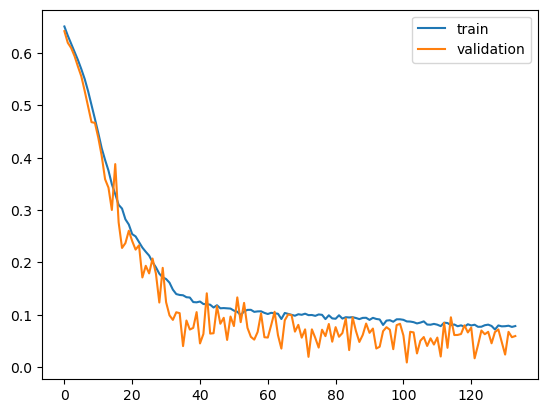

In [34]:
plt.plot(train_loss, label = "train")
plt.plot(val_loss, label = "validation")
plt.legend()
plt.show()

In [35]:
preds_suicatt = []
with torch.no_grad():
  for i in range(X.shape[0]):
    x = torch.stack([torch.tensor(X.iloc[a]) for a in [i]])
    y_pred = model(x.to(device = device, dtype=torch.float))
    preds_suicatt.append(torch.squeeze(y_pred).detach().numpy())

In [36]:
preds_suicatt = np.array(preds_suicatt)
preds_suicatt

array([0.00186178, 0.01521153, 0.01756269, ..., 0.00186178, 0.00186178,
       0.00146077], dtype=float32)

In [37]:
errors = y - preds_suicatt
errors

0      -0.001862
1      -0.015212
2      -0.017563
3      -0.009889
4       0.637960
          ...   
1256   -0.005396
1257   -0.042315
1258   -0.001862
1259   -0.001862
1260   -0.001461
Name: suicatt, Length: 1261, dtype: float64

In [38]:
errors.to_csv('result/errors_pred_suicatt.csv', index=False)

### Predict for ideation

In [39]:
y = suicide_db['ideation']
X = suicide_db[suicide_db.columns[[1,2,3,4,5,7,8,9,10,13,14,15,17,30,31]]].drop(columns='suicatt')

In [40]:
X['age'] = X['age'].apply(normalize)

In [41]:
seed = 257
rng = np.random.default_rng(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [42]:
total = list(range(y.shape[0]))
train_id = rng.choice(total, size = int(0.8*len(total)), replace = False)
val_test = [x for x in total if x not in train_id]
val_id = rng.choice(val_test, size = int(len(val_test)/2), replace = False)
test_id = [x for x in val_test if x not in val_id]

In [43]:
len(train_id), len(val_id), len(test_id)

(1008, 126, 127)

In [44]:
def get_batch(idx, X, y, batch_size):
    batch = rng.choice(idx, size = batch_size, replace = False)
    x = torch.stack([torch.tensor(X.iloc[i]) for i in batch])
    y_out = torch.stack([torch.tensor(y.iloc[i]) for i in batch])
    return batch, x.to(device = device, dtype=torch.float), y_out.to(device = device, dtype=torch.float)

In [45]:
batch_size = 64
input_dim = 14
output_dim = 1
epochs = 600

In [46]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_layer = nn.Linear(input_dim, 10)
        self.hidden_layer = nn.Linear(10, 5)
        self.output_layer = nn.Linear(5, output_dim)

    def forward(self, x):
        # x = [batch size, input_dim]
        h_1 = F.relu(self.input_layer(x))
        # h_1 = [batch size, 20]
        h_2 = F.relu(self.hidden_layer(h_1))
        # h_2 = [batch size, 10]
        y_pred = self.output_layer(h_2)
        # y_pred = [batch size, 1]
        return torch.sigmoid(y_pred)

In [47]:
model = MLP(input_dim, output_dim)
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

model = model.to(device)
criterion = criterion.to(device)

In [48]:
def train(model: nn.Module):
    model.train()
    total_loss = 0.
    start_time = time.time()

    n_batches = len(train_id) // batch_size
    aux_train = train_id
    for b in range(n_batches):
        batch, x, y_out = get_batch(aux_train, X, y, batch_size)
        aux_train = [x for x in aux_train if x not in batch]

        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(torch.squeeze(y_pred), y_out)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / n_batches

In [49]:
def evaluate(model: nn.Module, data_id):
    model.eval()
    total_loss = 0.

    with torch.no_grad():
        n_batches = len(data_id) // batch_size
        aux_data = data_id
        for b in range(n_batches):
            batch, x, y_out = get_batch(aux_data, X, y, batch_size)
            aux_data = [x for x in aux_data if x not in batch]

            y_pred = model(x)
            total_loss += criterion(torch.squeeze(y_pred), y_out).item()
    return total_loss / n_batches

In [50]:
best_val_loss = float('inf')
best_model_params_path = os.path.join('', "model.pt")

count = 0
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()

    total_train_loss = train(model)
    with open("train_model_id.txt", "a") as f:
        f.write(str(total_train_loss)+',')
        f.close()

    total_val_loss = evaluate(model, val_id)
    with open("val_model_id.txt", "a") as f:
        f.write(str(total_val_loss)+',')
        f.close()

    elapsed = time.time() - epoch_start_time
    print('-' * 72)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
        f'train loss {total_train_loss:5.2f} | valid loss {total_val_loss:5.2f}')
    print('-' * 72)

    if total_val_loss < best_val_loss:
        count = 0
        best_val_loss = total_val_loss
        torch.save(model.state_dict(), best_model_params_path)
    elif count > 30:
        print('EARLY STOPPING')
        break
    elif np.round(total_train_loss, 2) == 0:
      break
    else:
        count += 1

model.load_state_dict(torch.load(best_model_params_path))

------------------------------------------------------------------------
| end of epoch   1 | time:  1.06s | train loss  0.79 | valid loss  0.78
------------------------------------------------------------------------


------------------------------------------------------------------------
| end of epoch   2 | time:  1.08s | train loss  0.76 | valid loss  0.75
------------------------------------------------------------------------
------------------------------------------------------------------------
| end of epoch   3 | time:  0.73s | train loss  0.74 | valid loss  0.72
------------------------------------------------------------------------
------------------------------------------------------------------------
| end of epoch   4 | time:  0.79s | train loss  0.71 | valid loss  0.69
------------------------------------------------------------------------
------------------------------------------------------------------------
| end of epoch   5 | time:  0.51s | train loss  0.67 | valid loss  0.66
------------------------------------------------------------------------
------------------------------------------------------------------------
| end of epoch   6 | time:  0.72s | train loss  0.64 | 

<All keys matched successfully>

In [51]:
total_test_loss = evaluate(model, test_id)
total_test_loss

0.025654515251517296

In [52]:
preds = []
with torch.no_grad():
  for i in test_id:
    batch, x, y_out = get_batch(i, X, y, 1)
    y_pred = model(x)
    preds.append(torch.squeeze(y_pred).detach().numpy())

In [53]:
threshold = 0.5
y_pred = []
for i in preds:
  if i > threshold:
    y_pred.append(1)
  else:
    y_pred.append(0)

y_true = []
for i in test_id:
  y_true.append(int(y.iloc[i]))

In [54]:
precision_recall_fscore_support(y_true, y_pred, average='macro'), precision_recall_fscore_support(y_true, y_pred, average='micro')

((0.47663971248876913, 0.4592476489028213, 0.4636824324324324, None),
 (0.7637795275590551, 0.7637795275590551, 0.7637795275590551, None))

In [55]:
f = open("train_model_id.txt", "r")
train_loss = f.read().split(',')
train_loss = [float(i) for i in train_loss[:-1]]
f.close()
f = open("val_model_id.txt", "r")
val_loss = f.read().split(',')
val_loss = [float(i) for i in val_loss[:-1]]
f.close()

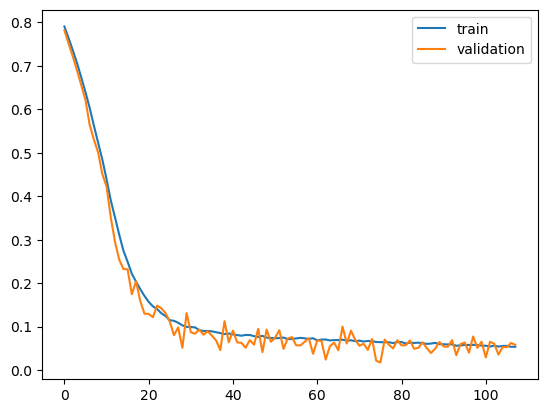

In [56]:
plt.plot(train_loss, label = "train")
plt.plot(val_loss, label = "validation")
plt.legend()
plt.show()

In [57]:
preds_ideation = []
with torch.no_grad():
  for i in range(X.shape[0]):
    x = torch.stack([torch.tensor(X.iloc[a]) for a in [i]])
    y_pred = model(x.to(device = device, dtype=torch.float))
    preds_ideation.append(torch.squeeze(y_pred).detach().numpy())

In [58]:
preds_ideation = np.array(preds_ideation)
preds_ideation

array([0.00069385, 0.00245297, 0.00139595, ..., 0.00069385, 0.00069385,
       0.00030323], dtype=float32)

In [59]:
errors = y - preds_ideation
errors

0      -0.000694
1      -0.002453
2      -0.001396
3      -0.001733
4       0.407680
          ...   
1256   -0.003816
1257    0.407680
1258   -0.000694
1259   -0.000694
1260   -0.000303
Name: ideation, Length: 1261, dtype: float64

In [60]:
errors.to_csv('errors_pred_ideation.csv', index=False)